<p style="background-image: url(https://assets.vogue.com/photos/65f8604e619fe40d5e1b0301/master/pass/western_Trends_001.jpg);font-family:Pacifico ,cursive;font-size:200%; color:black; text-align:center; border-radius: 20%; padding:20px; font-weight: normal; border: 3px dashed #14adc6; box-shadow: 0px 5px 10px  rgba(0, 0, 0, 0.2);text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.4); background-size: cover; background-repeat: no-repeat; background-position: center;">AI Fashion Recommender</p>

In [90]:
pip install swifter

Note: you may need to restart the kernel to use updated packages.


In [91]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import datasets
import cv2
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from pandas.core.common import flatten
from torchvision.transforms import transforms
import torchvision.models as models
from torch.autograd import Variable
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import swifter


In [92]:
# Read dataset
fashion_data = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv', on_bad_lines='skip')

In [93]:
# Add image column
fashion_data['image_path'] = fashion_data.apply(lambda row: str(row['id']) + '.jpg', axis=1)
fashion_data = fashion_data.reset_index(drop=True)


In [94]:
# Function to get the path of an image
def get_image_path(image_name):
    base_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"
    full_path = base_path + image_name
    return full_path


In [95]:
# Function to import an image
def load_image(image_name):
    image = cv2.imread(get_image_path(image_name))
    return image


In [96]:
# Function to show images in a grid format
def display_images(image_dict, rows=1, cols=1, figsize=(12, 12)):
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=figsize)
    
    for idx, name in enumerate(image_dict):
        axes.ravel()[idx].imshow(cv2.cvtColor(image_dict[name], cv2.COLOR_BGR2RGB))
        axes.ravel()[idx].set_title(name)
        axes.ravel()[idx].set_axis_off()
    
    plt.tight_layout()


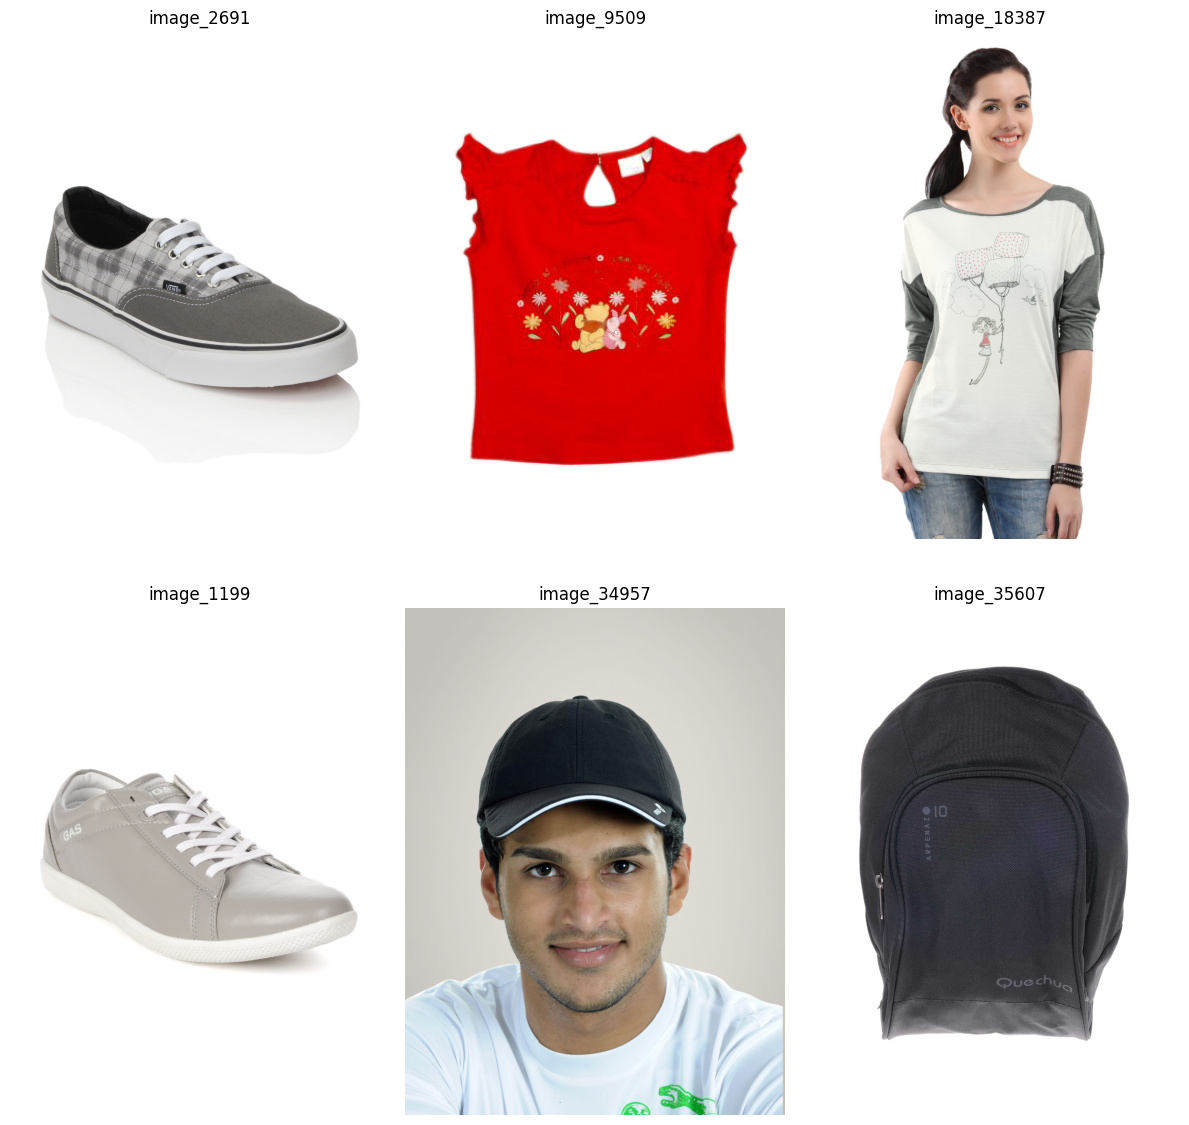

In [97]:
# Sample images for display
sample_images = {'image_' + str(i): load_image(row.image_path) for i, row in fashion_data.sample(6).iterrows()}
display_images(sample_images, 2, 3)


In [98]:
# Image size settings
img_width, img_height = 224, 224


In [99]:
# Load pretrained model
resnet_model = models.resnet18(pretrained=True)

In [100]:
# Select the layer to extract embeddings from
selected_layer = resnet_model._modules.get('avgpool')


In [101]:
# Image transformations
resize_transform = transforms.Resize((224, 224))
normalize_transform = transforms.Normalize(mean=[0.7, 0.6, 0.3], std=[0.2, 0.3, 0.1])
to_tensor_transform = transforms.ToTensor()


In [102]:
# List to store missing images
missing_images = []

# Function to extract image embeddings
def extract_image_embeddings(model, image_name):
    try:
        img = Image.open(get_image_path(image_name)).convert('RGB')
        transformed_img = Variable(normalize_transform(to_tensor_transform(resize_transform(img))).unsqueeze(0))
        
        # Create empty tensor for embedding
        embedding = torch.zeros(512)
        
        # Hook to save the output of the selected layer
        def save_embedding(module, input, output):
            embedding.copy_(output.data.reshape(output.data.size(1)))
        
        hook_layer = selected_layer.register_forward_hook(save_embedding)
        model(transformed_img)
        hook_layer.remove()
        
        return embedding
    
    except FileNotFoundError:
        # Add missing image index to the list
        missing_index = fashion_data[fashion_data['image_path'] == image_name].index
        missing_images.append(missing_index)

In [103]:
# Example of extracting embeddings for the first image
embedding_sample = extract_image_embeddings(resnet_model, fashion_data.iloc[0].image_path)


(2400, 1800, 3)


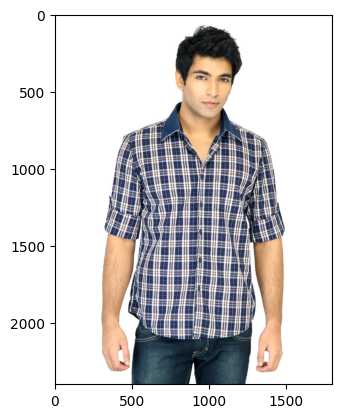

In [104]:
# Display the sample image and its shape
sample_image_array = load_image(fashion_data.iloc[0].image_path)
plt.imshow(cv2.cvtColor(sample_image_array, cv2.COLOR_BGR2RGB))
print(sample_image_array.shape)


In [105]:
# Compute cosine similarity between embeddings
cos_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim_result = cos_similarity(embedding_sample.unsqueeze(0), embedding_sample.unsqueeze(0))  # Example with same image
print('\nCosine Similarity: {0}\n'.format(cos_sim_result))



Cosine Similarity: tensor([1.0000])



In [106]:
# Get the first 5000 entries for embedding calculation
fashion_data_subset = fashion_data[:5000]


In [107]:
# Apply the embedding extraction to all images in the subset
fashion_embeddings = fashion_data_subset['image_path'].swifter.apply(lambda img: extract_image_embeddings(resnet_model, img))


Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

In [108]:
# Convert the embeddings to a DataFrame and save to CSV
embedding_df = fashion_embeddings.apply(pd.Series)
embedding_df.to_csv('fashion_embeddings.csv')


In [109]:
# Load embeddings from CSV
embedding_df = pd.read_csv('fashion_embeddings.csv')
embedding_df.drop(['Unnamed: 0'], axis=1, inplace=True)
embedding_df.dropna(inplace=True)


In [110]:
# Save embeddings as a pickle file
joblib.dump(embedding_df, 'fashion_embeddings.pkl', 9)


['fashion_embeddings.pkl']

In [111]:
# Load the pickle file
loaded_embeddings = joblib.load('./fashion_embeddings.pkl')


In [112]:
# Compute cosine similarity for all embeddings
similarity_matrix = cosine_similarity(loaded_embeddings)
print(similarity_matrix[:4, :4])


[[1.         0.99814039 0.99814856 0.9981748 ]
 [0.99814039 1.         0.99811852 0.99839729]
 [0.99814856 0.99811852 1.         0.99815232]
 [0.9981748  0.99839729 0.99815232 1.        ]]


In [113]:
# Create an index mapping for recommendations
index_mapping = pd.Series(range(len(fashion_data)), index=fashion_data.index)


In [114]:
# Function to recommend similar images
def get_similar_images(image_index, data, top_n=6):
    sim_index = index_mapping[image_index]
    similarity_scores = list(enumerate(similarity_matrix[sim_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:top_n+1]
    
    recommended_indices = [i[0] for i in similarity_scores]
    similarity_values = [i[1] for i in similarity_scores]
    
    return index_mapping.iloc[recommended_indices].index, similarity_values

In [115]:
# Example: Recommend images similar to image with index 3810
get_similar_images(3810, fashion_data, top_n=5)

(Index([284, 3555, 4818, 390, 3395], dtype='int64'),
 [0.9987809665198812,
  0.9987767455325334,
  0.998763064166533,
  0.9987352736738051,
  0.9987152384582239])

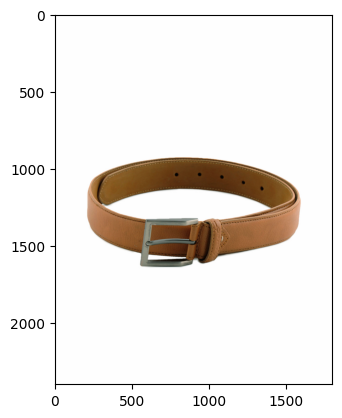

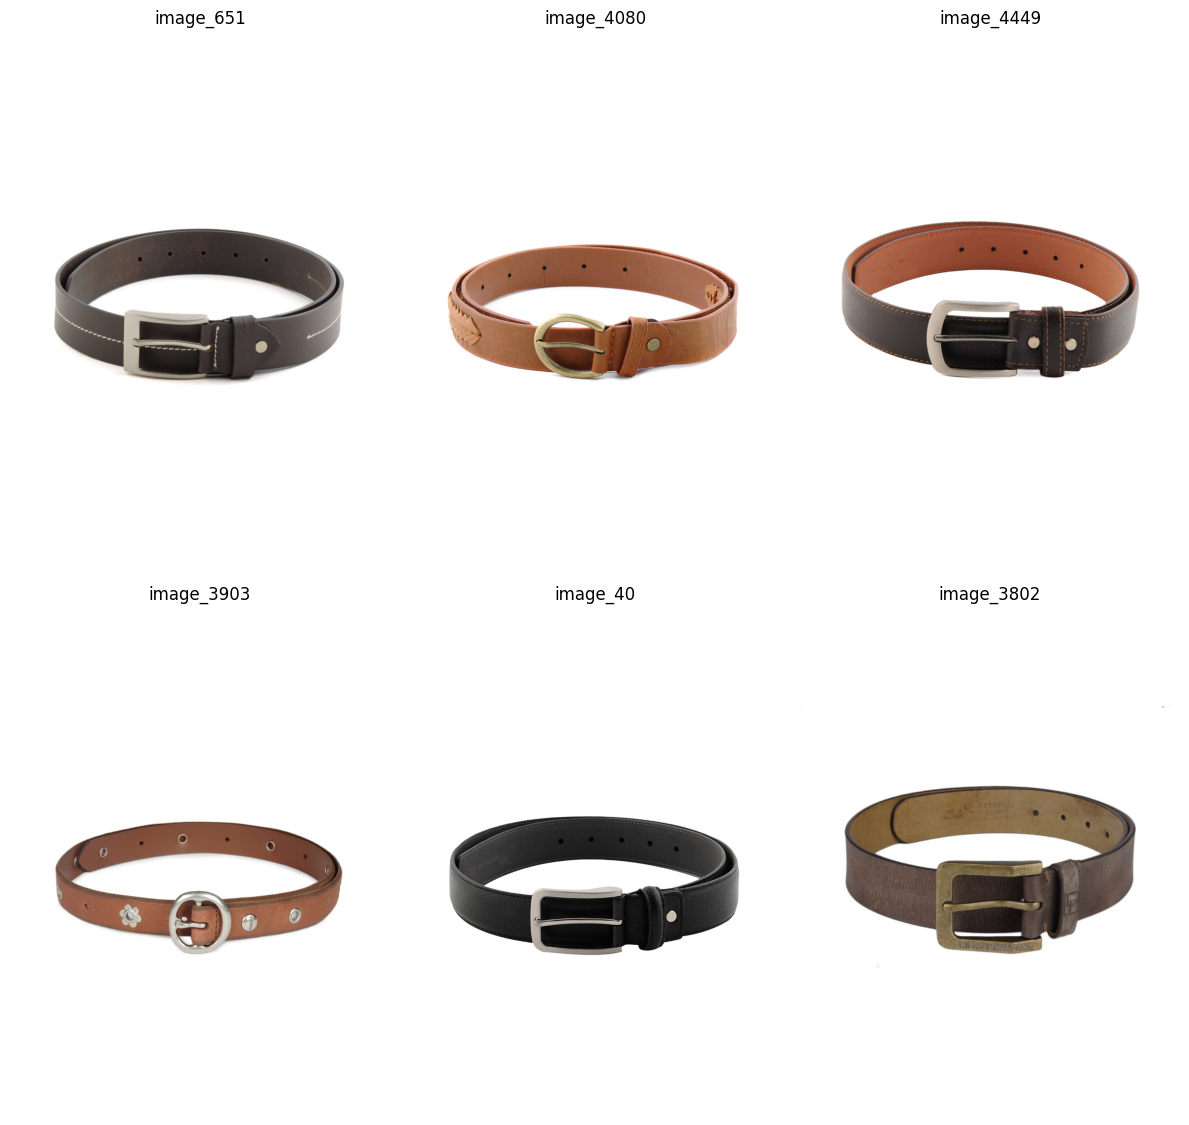

In [116]:
# Function to visualize recommendations
def visualize_recommendations(image_index):
    # Get recommended indices and similarities
    rec_indices, rec_similarities = get_similar_images(image_index, fashion_data, top_n=6)
    
    # Display the input image
    plt.imshow(cv2.cvtColor(load_image(fashion_data.iloc[image_index].image_path), cv2.COLOR_BGR2RGB))
    
    # Display the recommended images
    recommended_images = {'image_' + str(i): load_image(row.image_path) for i, row in fashion_data.loc[rec_indices].iterrows()}
    display_images(recommended_images, 2, 3)

# Example: Visualize recommendations for image with index 4810
visualize_recommendations(177)